### Formula:

$$
ln(\frac{P_H}{1-P_H}) = \beta_0 + X^Tw
$$

where $\beta_0$ is a scalar bias term, $x$ is a vector of the 10 successive time windows (100ms each) over the trial, and $w$ is a vector of the weights for each time window.

For my case, $ln(\frac{P_H}{1-P_H})$ can be substituted by the binary choice vector.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/gabriel/lib/')
import chiCa
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from utils import *

import warnings
warnings.filterwarnings('ignore')

%matplotlib widget

In [2]:
animal_ids = ['GRB005', 'GRB006', 'GRB007', 'GRB018']
paths_all_animals = {animal_id: get_file_names(animal_id, 'chipmunk', '*.mat') for animal_id in animal_ids}

Design matrix shape: (8364, 10)
Predictor vector shape: (8364,)
Mean cross-validated score: 0.717838258075949
Mean intercept value: 1.064847214701547


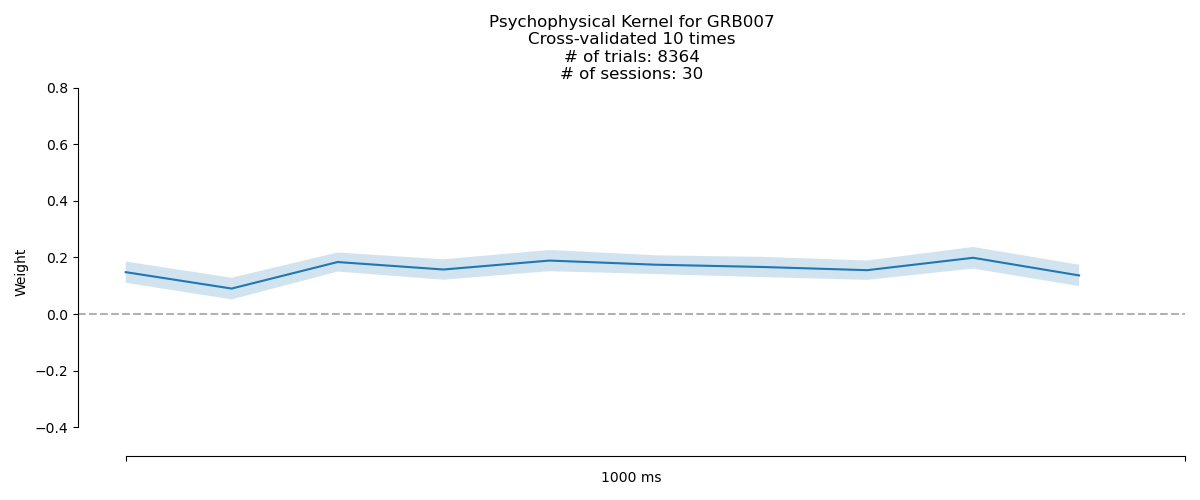

In [3]:
def plot_psychophysical_kernel(paths, animal, cv=10, timebins=10, n_last_sessions=50):
    all_residuals = []
    all_choices = []

    for session in paths[animal][-n_last_sessions:]:
        sesdata = chiCa.load_trialdata(session)
        choice = np.array(sesdata.response_side[(sesdata.response_side == 0) | (sesdata.response_side == 1)])
        stim_events = np.array(sesdata.stimulus_event_timestamps[(sesdata.response_side == 0) | (sesdata.response_side == 1)])
        residual = np.zeros((len(choice), timebins))
        for trial in range(len(choice)):
            bins = np.linspace(stim_events[trial][0], stim_events[trial][-1], num=timebins+1)
            SR = 20/len(bins) #SR = specific rate; 20 because that's the highest rate we can have
            IR, _ = np.histogram(stim_events[trial], bins=bins) #IR = instantaneous rate or counts per bin in this case
            residual[trial] = IR-SR #this is the residual rate
        all_residuals.append(residual)
        all_choices.append(choice)

    #concatenate across sessions
    X = np.concatenate(all_residuals)
    Y = np.concatenate(all_choices)

    kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=0)
    weight_list = []
    score_list = []
    bias_list = []
    err_list = []
    for train_index, test_index in kf.split(X, Y):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        model = LogisticRegression(penalty='l2', solver='liblinear', C=1, fit_intercept=True).fit(X_train, Y_train)

        predict_prob = model.predict_proba(X_train)
        V = np.product(predict_prob, axis=1)
        covariance_mat = np.linalg.pinv(np.dot(X_train.T*V, X_train))

        standard_err = np.sqrt(np.diag(covariance_mat))
        err_list.append(standard_err)

        weight = model.coef_[0]
        weight_list.append(weight)

        score = model.score(X_test, Y_test)
        score_list.append(score)

        bias = model.intercept_
        bias_list.append(bias)

    res = {'X':X, 'Y':Y, 'weights':weight_list, 'scores':score_list, 'bias':bias_list, 'error':err_list}
    
    print(f"Design matrix shape: {res['X'].shape}")
    print(f"Predictor vector shape: {res['Y'].shape}")
    print('Mean cross-validated score:', np.mean(res['scores']))
    print('Mean intercept value:', np.mean(res['bias']))

    weights_avg = np.mean(weight_list, axis=0)
    weights_err = np.mean(err_list, axis=0)

    plt.figure(figsize=(12, 5))
    plt.plot(weights_avg)
    plt.fill_between(range(len(weights_avg)), weights_avg - weights_err, weights_avg + weights_err, alpha=0.2)
    plt.ylabel('Weight')
    plt.xlabel('1000 ms')
    plt.ylim([-0.5, 0.8])
    plt.axhline(0, color='k', alpha=0.3, linestyle='--')
    
    tick_500ms = int(timebins * 500 / 1000)  # Position of the 500ms tick
    tick_1000ms = int(timebins * 1000 / 1000)  # Position of the 1000ms tick

    plt.xticks([0, tick_1000ms],['', ''])
    plt.title(f'Psychophysical Kernel for {animal}\nCross-validated {cv} times\n# of trials: {len(res["X"])}\n# of sessions: {n_last_sessions}')

    separate_axes(plt.gca())
    plt.tight_layout()

    return res

# Usage:
res = plot_psychophysical_kernel(paths_all_animals, 'GRB007', cv=10, timebins=10, n_last_sessions=30)

Design matrix shape: (3213, 10)
Predictor vector shape: (3213,)
Mean cross-validated score: 0.7746676728391477
Mean intercept value: 1.422367844999218


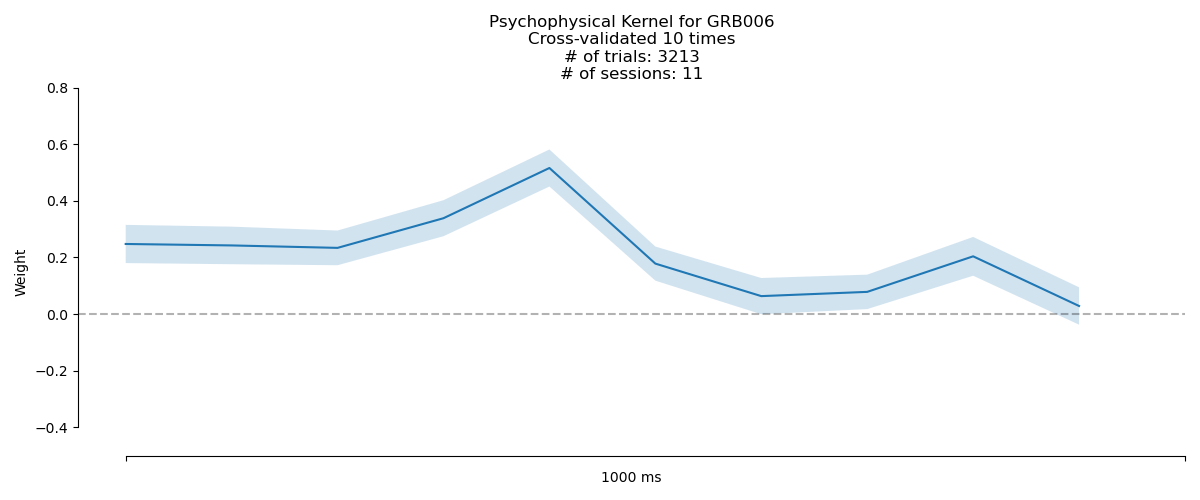

In [4]:
res = plot_psychophysical_kernel(paths_all_animals, 'GRB006', cv=10, timebins=10, n_last_sessions=11)

Design matrix shape: (2736, 10)
Predictor vector shape: (2736,)
Mean cross-validated score: 0.7459947594984092
Mean intercept value: 1.1528468128316924


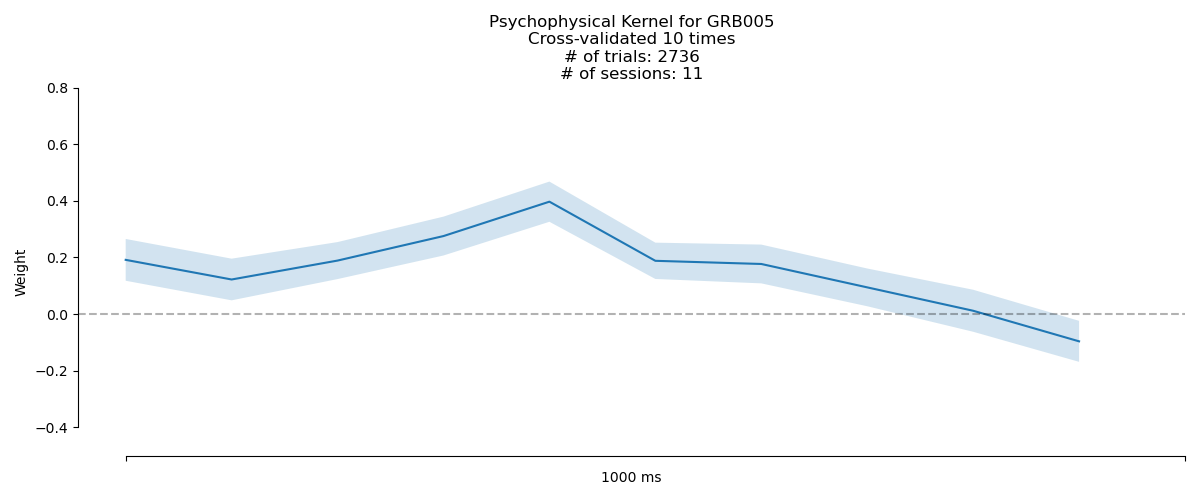

In [5]:
res = plot_psychophysical_kernel(paths_all_animals, 'GRB005', cv=10, timebins=10, n_last_sessions=11)

Design matrix shape: (1963, 10)
Predictor vector shape: (1963,)
Mean cross-validated score: 0.7738293794675231
Mean intercept value: 0.36449742831527354


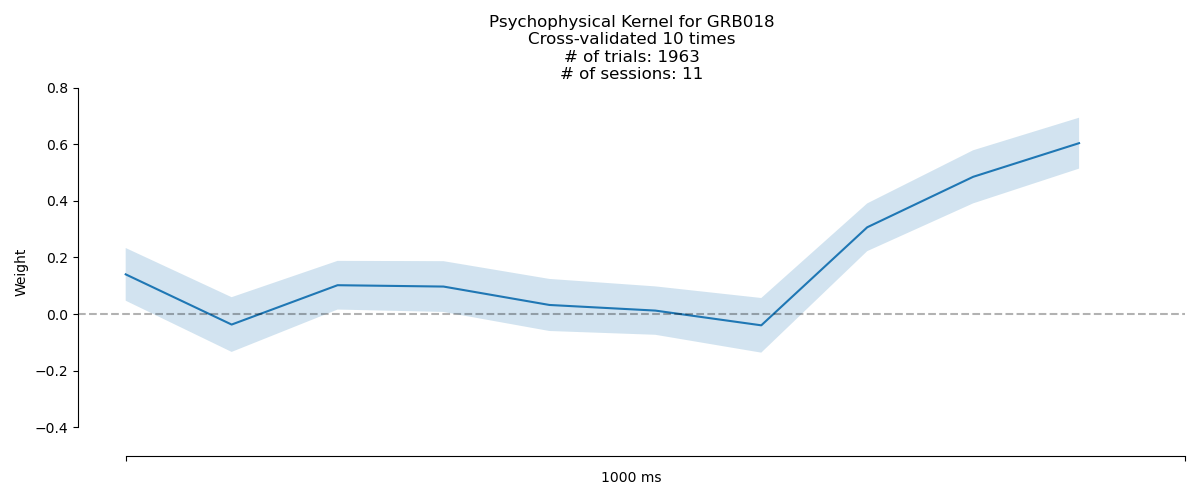

In [6]:
res = plot_psychophysical_kernel(paths_all_animals, 'GRB018', cv=10, timebins=10, n_last_sessions=11)